# MCMC Analysis and Plots
This notebook is to analyze MCMC walk data and produce relevant results plots

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Set up notebook and load some R68 constants (V, eps, etc.)
exec(open("nb_setup.py").read())#Is there a better way to do this?
from constants import *
import R68_spec_tools as spec
import R68_yield as Yield
from tqdm.notebook import tqdm

../mplstyles
3.1.1
/data/chocula/mast/cdms/analysis/run068/R68_paper2019/mplstyles
dict_keys(['xx', 'yy', 'ex', 'ey'])


In [3]:
#Turns out we need the helper functions to still be defined since the stored samplers rely on them.
#Don't think it matters if they're exactly the same as what was used, since we don't use them here.
def LindFit_helper(theta):
    return calc_log_prob(model='Lind', theta=theta, theta_bounds=((0,1),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

def ChavFit_helper(theta):
    return calc_log_prob(model='Chav', theta=theta, theta_bounds=((0,1),(1/10e3,1/0.1),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

def SorFit_helper(theta):
    return calc_log_prob(model='Sor', theta=theta, theta_bounds=((0,1),(0,3e-2),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')
def Fit_helper(theta):
    return calc_log_prob(model='Sor', theta=theta, theta_bounds=((0,1),(0,3e-2),(0,10),(0,5)),
                         spec_bounds=(5,101), likelihood='Pois')

In [19]:
#Load the MCMC data
import pickle as pkl

#fname='data/mcmc_Lind_128walk_5kstep_Pois_v1.pkl'
#fname='data/mcmc_Chav_128walk_5kstep_Pois_v1.pkl'
fname='data/mcmc_Sor_128walk_5kstep_Pois_v4.pkl'
#fname='data/mcmc_AC_128walk_5kstep_Pois_v1.pkl'
#fname='data/mcmc_Shexp_128walk_5kstep_Pois_v1.pkl'

############################
basename=os.path.splitext(os.path.basename(fname))[0]

results=pkl.load(open(fname,'rb'))
sampler=results['sampler']
guesses=results['guesses']
labels=results['labels']
model=results['Ymodel']

/home/mast/python/miniconda3/envs/nr_fano/lib/python3.6/site-packages/ipykernel_launcher.py:13: ResourceWarning: unclosed file <_io.BufferedReader name='data/mcmc_Sor_128walk_5kstep_Pois_v4.pkl'>
  del sys.path[0]


In [20]:
print(results['t_run']/60,' min')
print(results['theta_bounds'])

154.50523649454118  min
((0.05, 0.3), (0, 0.03), (0, 30), (0.1, 10), (0.1, 10))


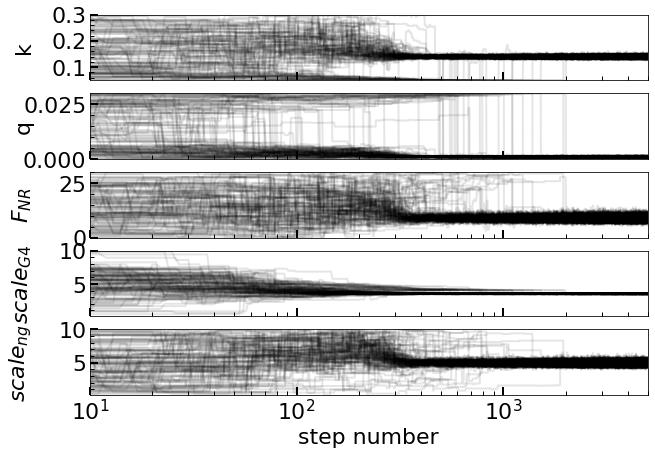

In [21]:
#Look at the chain of parameter values
#labels_l = [r'k', r'sim scale', r'$F_{NR}$']
#labels_c = [r'k', r'$a^{-1}$', r'sim scale', r'$F_{NR}$']
#labels_s = [r'k', r'q', r'sim scale', r'$F_{NR}$']

#if model=='Lind':
#    labels=labels_l
#elif model=='Chav':
#    labels=labels_c
#elif model=='Sor':
#    labels=labels_s


samples = sampler.get_chain()
ndim = samples.shape[2]

#Try a cut on crazy FNR chains
c_chain=samples[-1,:,2]<20

#Show autocorrelation timescales
taus=sampler.get_autocorr_time(tol=0)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i], "k", alpha=0.1)
    #ax.plot(samples[:,c_chain,i], "k", alpha=0.1)
    
    #ax.axvline(taus[i],color='r',linestyle='--')
    
    ax.set_xlim(10, len(samples))
    ax.set_ylim(*(results['theta_bounds'][i]))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)



axes[-1].set_xlabel("step number");
axes[-1].set_xscale("log");

plt.savefig('figures/mcmc/'+basename+'_chains.png')

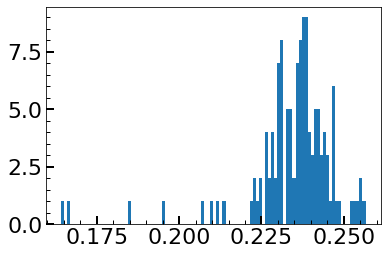

In [22]:
plt.hist(sampler.acceptance_fraction,bins=100);

In [23]:
#Get the sample autocorrelation times for each variable and use the largest one
#tol=0 gives an estimate, even if it's bad
tau=sampler.get_autocorr_time(tol=0)
print(tau)
avgtau=round(np.max(tau))
print(f'Avg tau={avgtau}, Max tau={np.max(tau)}')
print(f'Full chain is {samples.shape[0]/np.max(tau)} tau_max long')

[222.22961977 239.2562428  190.71182237 168.79502743 157.88827957]
Avg tau=239.0, Max tau=239.25624279554066
Full chain is 20.898096290314193 tau_max long


In [24]:
#Manually impose a value for short chains
#avgtau=100
#avgtau=200

#Discard a few times tau as burn-in and thin by tau/2
flat_samples = sampler.get_chain(discard=int(2.*avgtau), thin=int(round(avgtau/2.)), flat=True)
print(flat_samples.shape)

(4736, 5)


In [25]:
#Calculate the median and 1-sigma equivalent uncertainties
from IPython.display import display, Math

#Select a particular subset
ctest=flat_samples[:,2]<30


theta=np.zeros(ndim) #median param values
dtheta=np.zeros((ndim,2)) #1-sigma equivalents
for i in range(ndim):
    pcts = np.percentile(flat_samples[:, i], [16, 50, 84])
    theta[i]=pcts[1]
    dtheta[i] = np.diff(pcts)
    
    txt = r"\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(theta[i], dtheta[i][0], dtheta[i][1], labels[i])
    txt=txt.replace('$','')
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

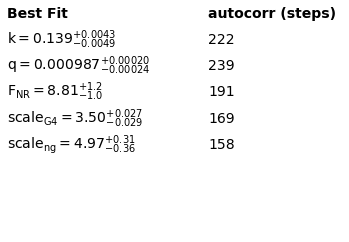

In [26]:
#Save a figure of some stats
fig,ax=plt.subplots()
ax.text(0,1,r'Best Fit',fontsize=14,fontweight='bold');
ax.text(0.6,1,r'autocorr (steps)',fontsize=14,fontweight='bold');

#txt = r'$\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}$'
txt = r'$\mathrm{{{3}}} = {0:#.3g}_{{-{1:#.2g}}}^{{+{2:#.2g}}}$'
for i in range(ndim):
    line = txt.format(theta[i], dtheta[i][0], dtheta[i][1], labels[i].replace('$',''))
    #ax.text(0,i*0.1,r'$\mathrm{F_{NR}}$',fontsize=14)
    ax.text(0,1-(i+1)*0.12,line,fontsize=14);
    ax.text(0.6,1-(i+1)*0.12,'{0:.0f}'.format(tau[i]),fontsize=14);
ax.axis('off');
plt.savefig('figures/mcmc/'+basename+'_stats.png')

<Figure size 1080x810 with 0 Axes>

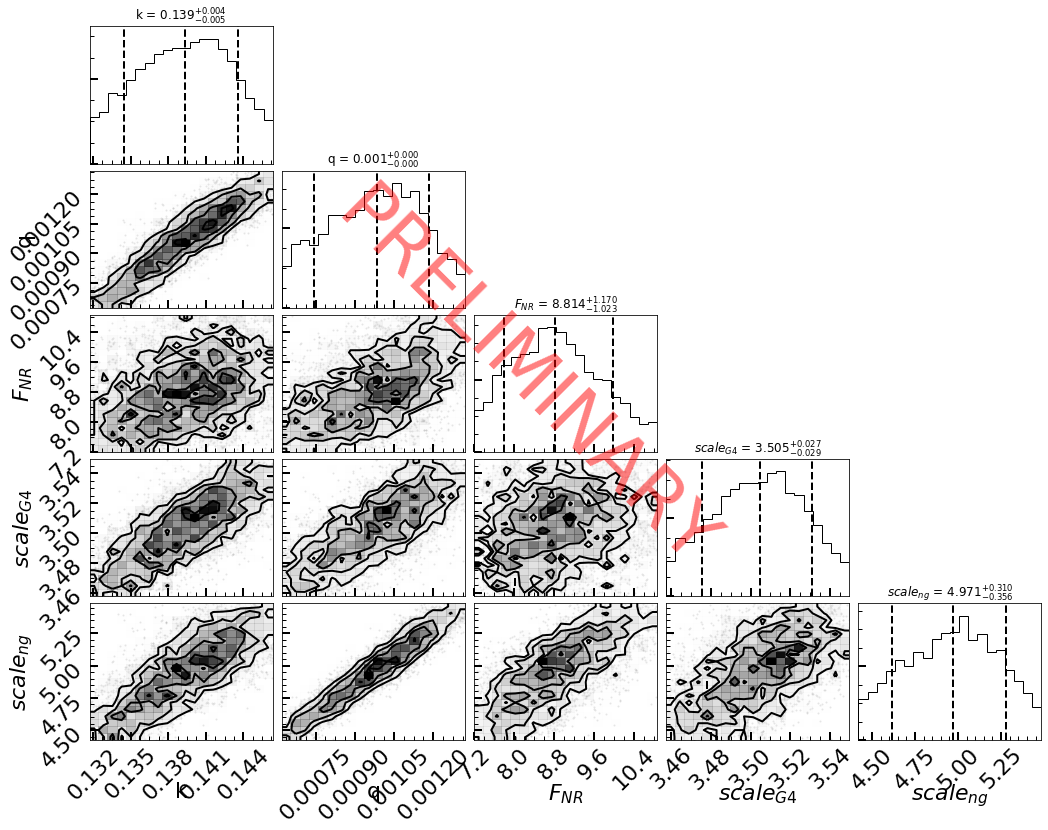

In [27]:
#Make the corner plots
import corner

#Full prior range
fig_w=15
fig,ax = plt.subplots(ndim,ndim,figsize=(fig_w, fig_w*(.75)))

fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='0.3f', 
    fig=fig,range=results['theta_bounds']);

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=75, alpha=0.5)
plt.savefig('figures/mcmc/'+basename+'_corner_full.png')

#Zoomed version
plt.clf()
fig,ax = plt.subplots(ndim,ndim,figsize=(fig_w, fig_w*(.75)))
fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_fmt='0.3f',
    fig=fig,range=[np.percentile(flat_samples[:,_], [5, 95]) for _ in range(ndim)]);

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=75, alpha=0.5)
plt.savefig('figures/mcmc/'+basename+'_corner.png')

# Show best fit spectrum

In [13]:
#Load the data
import R68_load as r68

meas=r68.load_measured()
#g4=r68.load_G4(load_frac=0.1)
#cap=r68.load_simcap(file='/data/chocula/villaa/cascadeSimData/si28_R68_400k.pkl', rcapture=0.161, load_frac=0.1)
    
g4=r68.load_G4(load_frac=results['g4_load_frac'])
cap=r68.load_simcap(file=results['cap_sim_file'], rcapture=results['cap_rcapture'], load_frac=results['cap_load_frac'])

Loading Measured Data...
(480634,)
(174510,)
Loading Geant4 Data...
(528848, 7)
(129555, 7)
Loading NRs...
1.1  min
Loading ERs...
0.3  min
Loading (n,gamma) Data...
400000


In [28]:
#Energy binning
#Emax = 2000 #eVee
#Ebins=np.linspace(0,Emax,201)

Emax=results['Emax']
Ebins=results['Ebins']

Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

#Changed on 14 Feb 2020 for speed
#Emax = 1000 #eVee 
#Ebins=np.linspace(0,Emax,101)
#Ebin_ctr=(Ebins[:-1]+Ebins[1:])/2

############
##Playing around
##COMMENT OUT
############
#cal_scale=1

#Measured spectra
#N_meas_PuBe,_ = np.histogram(cal_scale*meas['PuBe']['E'],bins=Ebins)
#N_meas_Bkg,_ = np.histogram(cal_scale*meas['Bkg']['E'],bins=Ebins)


#R_meas = N_meas_PuBe/meas['PuBe']['tlive']-N_meas_Bkg/meas['Bkg']['tlive']
#dR_meas = np.sqrt( N_meas_PuBe/(meas['PuBe']['tlive']**2) + N_meas_Bkg/(meas['Bkg']['tlive']**2) )



#Measured spectra
N_meas_PuBe,_ = np.histogram(meas['PuBe']['E'],bins=Ebins)
N_meas_Bkg,_ = np.histogram(meas['Bkg']['E'],bins=Ebins)

tlive_PuBe = meas['PuBe']['tlive']
tlive_Bkg = meas['Bkg']['tlive']
#We'll scale everything to the PuBe live time and work with counts, not rate, to get the Poisson stats right

N_meas_Bkg_scaled = N_meas_Bkg * tlive_PuBe/tlive_Bkg
#Estimate of counts due to PuBe
N_meas = N_meas_PuBe - N_meas_Bkg_scaled
dN_meas=np.sqrt(N_meas_PuBe + N_meas_Bkg_scaled*(tlive_PuBe/tlive_Bkg)**2)

#g4 Simulations
#Trim events that won't figure into the analysis range
#Trimmed sim data
Eee_er=np.sum(g4['ER']['E'],axis=1)
Evec_er_cut=(Eee_er>10) & (Eee_er<3e3)
Evec_er=g4['ER']['E'][Evec_er_cut]

Eee_nr=np.sum(g4['NR']['E'],axis=1)
Evec_nr_cut=(Eee_nr>10) & (Eee_nr<30e3)
Evec_nr=g4['NR']['E'][Evec_nr_cut]

#Simulated ER spectrum
N_er = spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_er, Yield=1.0, F=F, scale=1, 
                                   doDetRes=results['doDetRes'], fpeak=results['fpeak'])                                                             

In [29]:
#Y=Yield.Yield('Lind',[0.2])

#if model=='Lind':
#    nYpar=1
#elif (model=='Chav' or model=='Sor'):
#    nYpar=2
#elif (model=='Damic'):
#    nYpar=0
#else:
#    print('Error: Yield model not defined.')

#Y.model=model
#Y.pars=theta[:nYpar]
#F_NR=theta[nYpar]
#scale_g4=theta[nYpar+1]
#scale_ng=theta[nYpar+2]
    
Y=Yield.Yield('Lind',[0.2])

Y.set_model(results['Ymodel'])
nYpar=Y.model_npar[results['Ymodel']]
Y.set_pars(theta[:nYpar])
Y.solve()

F_NR=theta[nYpar]
scale_g4=theta[nYpar+1]
scale_ng=theta[nYpar+2]

#######################
#Playing around
#COMMENT OUT
#######################

#Y=Yield.Yield('Damic',[])
#Slow, just use this
#Y=Yield.Yield('Chav',[0.146,1/(0.247e-3)])
#F_NR=1
#scale_g4*=0.75
#scale_ng*=1

#Y=Yield.Yield('Chav',[0.12,800])
#F_NR=0.3
#scale_g4*=1
#scale_ng*=2

#cutoff=100 #eV_NR
#q=11.5*14**(-7./3)*cutoff*1e-3
#Y=Yield.Yield('Sor',[0.17,q])
#F_NR=1
#scale_g4*=1.2
#scale_ng*=2.8

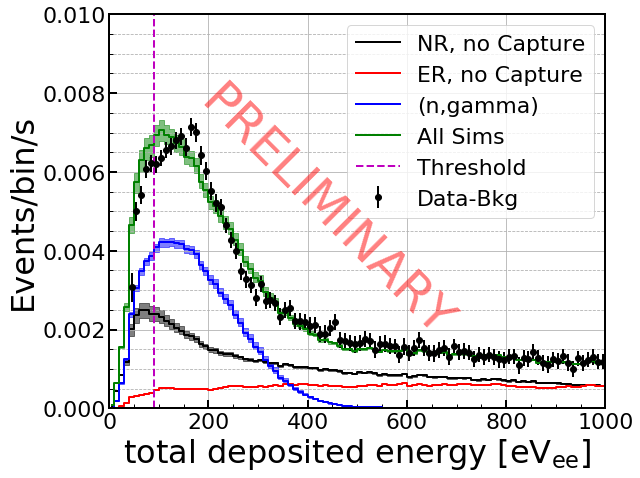

In [30]:
plotBest=False #Plot just the best fit spectrum
saveSpec=True

if plotBest:
    #NR,ER,NG=spec.buildAvgSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
    #                             Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True, fpeak=1)
    #spec.plotSpectra(E_bins=Ebins, N_nr=NR/g4['NR']['tlive'], N_er=ER/g4['ER']['tlive'],
    #                 N_ng=NG/cap['tlive'], N_meas=R_meas, dN_meas=dR_meas,
    #                 xrange=(0,1.75e3), yrange=(0,1e-2), thresh=Ebins[np.digitize(50,Ebins)-1])
    
    Y.set_model(results['Ymodel'])
    nYpar=Y.model_npar[results['Ymodel']]
    Y.set_pars(theta[:nYpar])
    Y.solve()
    
    #NR
    N_nr=spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_nr, Yield=Y, F=F_NR, scale=1, 
                                               doDetRes=results['doDetRes'], fpeak=results['fpeak'])
    #Simulated ER spectrum
    N_er = spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_er, Yield=1.0, F=F, scale=1, 
                                   doDetRes=results['doDetRes'], fpeak=results['fpeak'])  
    #(n,gamma)
    N_ng=spec.buildAvgSimSpectrum_ee_composite(Ebins=Ebins, Evec=cap['E'], dEvec=cap['dE'], Yield=Y, F=F_NR, scale=1, 
                                               doDetRes=results['doDetRes'], fpeak=results['fpeak'])
    
    #N_pred = (N_nr*scale_g4/g4['NR']['tlive'] + N_er*scale_g4/g4['ER']['tlive'] + N_ng*scale_ng/cap['tlive'])*tlive_PuBe
    
    ax=spec.plotSpectra(E_bins=Ebins, N_nr=N_nr*scale_g4/g4['NR']['tlive'], N_er=N_er*scale_g4/g4['ER']['tlive'],
                     N_ng=N_ng*scale_ng/cap['tlive'], N_meas=N_meas/tlive_PuBe, dN_meas=dN_meas/tlive_PuBe,
                     xrange=(0,1e3), yrange=(0,1e-2), thresh=Ebins[np.digitize(results['Efit_min'],Ebins)-1], 
                     wResidual=False, yrange_res=(-1e-3,1e-3))
    
else:
    N_nr_plot=list()
    N_er_plot=list()
    N_ng_plot=list()
    
    ####Median Params
    Y.set_model(results['Ymodel'])
    nYpar=Y.model_npar[results['Ymodel']]
    Y.set_pars(theta[:nYpar])
    Y.solve()
    
    #NR
    N_nr=spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_nr, Yield=Y, F=F_NR, scale=1, 
                                               doDetRes=results['doDetRes'], fpeak=results['fpeak'])
    #Simulated ER spectrum
    N_er = spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_er, Yield=1.0, F=F, scale=1, 
                                   doDetRes=results['doDetRes'], fpeak=results['fpeak'])  
    #(n,gamma)
    N_ng=spec.buildAvgSimSpectrum_ee_composite(Ebins=Ebins, Evec=cap['E'], dEvec=cap['dE'], Yield=Y, F=F_NR, scale=1, 
                                               doDetRes=results['doDetRes'], fpeak=results['fpeak'])
    
    N_nr_plot.append(N_nr)
    N_er_plot.append(N_er)
    N_ng_plot.append(N_ng)
    
    #Range of curves
    nYpar=Y.model_npar[results['Ymodel']]
    inds = np.random.randint(len(flat_samples), size=100)
    
    N_nrs=list()
    N_ers=list()
    N_ngs=list()
    
    for i,ind in enumerate(tqdm(inds)):
        thetai = flat_samples[ind]
        Y.set_pars(thetai[:nYpar])
        Y.solve()
        
        #NR
        N_nr=spec.buildAvgSimSpectrum_ee(Ebins=Ebins, Evec=Evec_nr, Yield=Y, F=F_NR, scale=1, 
                                               doDetRes=results['doDetRes'], fpeak=results['fpeak'])
        #(n,gamma)
        N_ng=spec.buildAvgSimSpectrum_ee_composite(Ebins=Ebins, Evec=cap['E'], dEvec=cap['dE'], Yield=Y, F=F_NR, scale=1, 
                                               doDetRes=results['doDetRes'], fpeak=results['fpeak'])
        
        N_nrs.append(N_nr)
        N_ers.append(N_er)
        N_ngs.append(N_ng)
    
    N_nrs=np.array(N_nrs)
    N_ers=np.array(N_ers)
    N_ngs=np.array(N_ngs)
    
    #Best fit spectrum, then upper lim, then lower lim
    N_nr_plot.append(np.percentile(N_nrs, 84,axis=0))
    N_nr_plot.append(np.percentile(N_nrs, 16,axis=0))
    
    N_er_plot.append(np.percentile(N_ers, 84,axis=0))
    N_er_plot.append(np.percentile(N_ers, 16,axis=0))

    N_ng_plot.append(np.percentile(N_ngs, 84,axis=0))
    N_ng_plot.append(np.percentile(N_ngs, 16,axis=0))
    
    
    N_nr_plot=np.array(N_nr_plot)
    N_er_plot=np.array(N_er_plot)
    N_ng_plot=np.array(N_ng_plot)
    
    spec.plotSpectra(E_bins=Ebins, N_nr=N_nr_plot*scale_g4/g4['NR']['tlive'], N_er=N_er_plot*scale_g4/g4['ER']['tlive'],
                     N_ng=N_ng_plot*scale_ng/cap['tlive'], N_meas=N_meas/tlive_PuBe, dN_meas=dN_meas/tlive_PuBe,
                     xrange=(0,1e3), yrange=(0,1e-2), thresh=Ebins[np.digitize(results['Efit_min'],Ebins)-1],
                     wResidual=False, yrange_res=(-1e-3,1e-3))

plt.gcf().text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=50, alpha=0.5);

if saveSpec:
    plt.savefig('figures/mcmc/'+basename+'_spectrum.png')

# Yield curve

In [31]:
from scipy.optimize import fsolve
from scipy.special import erf

def ERtoNR(ER,Y,V,eps):
    func = lambda NR : NR-ER*(1+V/eps)/(1+Y.calc(NR)*V/eps)
    NR_guess = ER
    return fsolve(func, NR_guess)

def NRtoER(NR,Y,V,eps):
    return NR*(1+Y.calc(NR)*V/eps)/(1+V/eps)

#TODO: Under development
#Plot the uncertainty band of yield curves for a set of parameter samples
#
#ax: axis to plot on 
#Er_plot: Array of Er energies to plot over
#Y: Yield model
#theta: optimal parameters
#flat_samples: trimmed and thinned selection of mcmc chain values
#nsigma: number of sigma width to plot
#nsample: number of examples from flat_samples to use inclaculating the distribution
def plotYband(ax,Er_plot,Y,theta,flat_samples,nsigma=1,nsample=100):
    nYpar=Y.model_npar[results['Ymodel']]
    inds = np.random.randint(len(flat_samples), size=nsample)
    Ycurves=np.zeros((nsample,len(Er_plot)))
    for i,ind in enumerate(inds):
        thetai = flat_samples[ind]
        Y.set_pars(thetai[:nYpar])
        Y.solve()
        Ycurves[i]=Y.calc(Er_plot).flatten()
    
    #Ymeans=np.mean(Ycurves,axis=0)
    #Ysigmas=np.std(Ycurves,axis=0)
    
    #ax.fill_between(Er_plot,Ymeans-nsigma*Ysigmas,Ymeans+nsigma*Ysigmas,color='lightgray')
    #ax.plot(Er_plot, Ymeans, '-k', linewidth=2)
    #ax.plot(Er_plot, Ymeans-nsigma*Ysigmas, '-k', linewidth=1)
    #ax.plot(Er_plot, Ymeans+nsigma*Ysigmas, '-k', linewidth=1)
    #Calc percentiles from sigma
    plow=0.5*(1-0.5*(erf(nsigma/np.sqrt(2))-erf(-nsigma/np.sqrt(2))))
    phi=1-plow
    Ydist=np.percentile(Ycurves,[100*plow,50,100*phi],axis=0)
    
    ax.fill_between(Er_plot,Ydist[0],Ydist[2],color='lightgray')
    ax.plot(Er_plot, Ydist[1], '-k', linewidth=2)
    ax.plot(Er_plot, Ydist[0], '-k', linewidth=1)
    ax.plot(Er_plot, Ydist[2], '-k', linewidth=1)
    
    Y.set_pars(theta[:nYpar])
    Y.solve()
    ax.plot(Er_plot, Y.calc(Er_plot), '--k', linewidth=2)
    

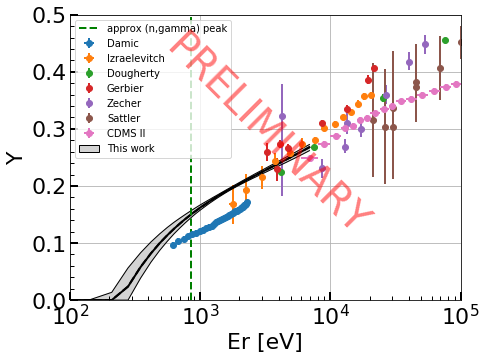

In [32]:
import R68_plot_tools as pt
import matplotlib.patches as mpatches

#Plot best fit yield (comment out to use Y from above)
#Y=Yield.Yield('Lind',[0.2])
#Y.pars=theta[:1]

#This work
Y=Yield.Yield('Lind',[0.2])
Y.set_model(results['Ymodel'])
nYpar=Y.model_npar[results['Ymodel']]
Y.set_pars(theta[:nYpar])
Y.solve()
thresh_low_NR=ERtoNR(50,Y,V,eps)[0]
thresh_high_NR=ERtoNR(2000,Y,V,eps)[0]

fig_w=7
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))


#TODO: Determine this range
#Er_plot=np.linspace(thresh_low_NR,thresh_high_NR,100)
Er_plot=np.linspace(0,thresh_high_NR,100)

#Add other measurements from lit
pt.plotOldYs(ax,fmt='o')

#TEST
#ax.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=1, linewidth=5)


#inds = np.random.randint(len(flat_samples), size=100)
#for ind in inds:
    #thetai = flat_samples[ind][0]
    #Y=Yield.Yield('Lind',[thetai])
    #ax.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)
    
    #thetai = flat_samples[ind]
    #if model=='Lind':
    #    Y.pars=thetai[:1]
    #elif (model=='Chav' or model=='Sor'):
    #    Y.pars=thetai[:2]
    #elif (model=='Damic'):
    #    Y.pars=[]
    
#    thetai = flat_samples[ind]
#    Y.set_pars(thetai[:nYpar])
    
#    ax.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)


plotYband(ax,Er_plot,Y,theta,flat_samples,nsigma=1,nsample=1000)

ax.axvline(ERtoNR(150,Y,V,eps), color='g', linestyle='--', label='approx (n,gamma) peak')
    
#ax.axvline(thresh_low_NR, color='m', linestyle='--', label='Analysis range')
#ax.axvline(thresh_high_NR, color='m', linestyle='--')

#Example Lindhard curves
#Er_full=np.logspace(2,5,100)
#Y=Yield.Yield('Lind',[0.146])
#ax.plot(Er_full, Y.calc(Er_full), '--k')
#Y=Yield.Yield('Chav',[0.15,0.247])
#ax.plot(Er_full, Y.calc(Er_full), '--k')

#Manually add legend entry
handles, Ylabels = ax.get_legend_handles_labels()
patch = mpatches.Patch(facecolor='lightgray',edgecolor='k', label='This work')
handles.append(patch) 

ax.legend(handles=handles, loc='upper left')

ax.set_xscale('log')
ax.set_xlabel('Er [eV]')
ax.set_ylabel('Y')
ax.set_xlim(1e2,1e5);
ax.set_ylim(0,0.5);
ax.grid()

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)

#plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_yield_compare.png')
plt.savefig('figures/mcmc/'+basename+'_yield_compare.png')

How to determine the range over which we trust this yield? Let's also histogram all the Ers at which we evaluated the yield, so  we can see how densely we probed it.

In [ ]:
#Direct NRs
evec_nr=g4['NR']['E']
evec_Nnr=g4['NR']['N']

#Select events which end up in the analysis ROI
Eee_nr = np.sum(evec_nr*(1 + Y.calc(evec_nr)*V/eps)/(1+V/eps),1)
evec_nr=evec_nr[(Eee_nr>50) & (Eee_nr<1000)]
evec_Nnr=evec_Nnr[(Eee_nr>50) & (Eee_nr<1000)]

#Separate out singles and multiples
evec_nr_sing=evec_nr[(evec_Nnr==1).flatten()]
evec_nr_mult=evec_nr[(evec_Nnr!=1).flatten()]

#Flatten and remove 0's
evec_nr_sing=evec_nr_sing[evec_nr_sing!=0].flatten()
evec_nr_mult=evec_nr_mult[evec_nr_mult!=0].flatten()

In [ ]:
#(n,gamma)
evec_ng=cap['E']
devec_ng=cap['dE']
evec_Nng=cap['N']

#Select events which end up in the analysis ROI
evec_ng_eion = evec_ng*Y.calc(evec_ng) - (evec_ng-devec_ng)*Y.calc(evec_ng-devec_ng)
Eee_ng = np.sum((devec_ng + evec_ng_eion*V/eps)/(1+V/eps),1)
evec_ng=evec_ng[(Eee_ng>50) & (Eee_ng<2000)]
devec_ng=devec_ng[(Eee_ng>50) & (Eee_ng<2000)]
evec_Nng=evec_Nng[(Eee_ng>50) & (Eee_ng<2000)]

#Separate out singles and multiples
evec_ng_sing=evec_ng[(evec_Nng==1).flatten()]
evec_ng_mult=evec_ng[(evec_Nng!=1).flatten()]
#Flatten and remove 0's
evec_ng_sing=evec_ng_sing[evec_ng_sing!=0].flatten()
evec_ng_mult=evec_ng_mult[evec_ng_mult!=0].flatten()

In [ ]:
#Make histograms
Emax_Er = 3500 #eVee
Ebins_Er=np.linspace(0,Emax_Er,101)
Ebins_Er_ctr=(Ebins_Er[:-1]+Ebins_Er[1:])/2

n_nr_sing,_=np.histogram(evec_nr_sing, bins=Ebins_Er)
n_nr_mult,_=np.histogram(evec_nr_mult, bins=Ebins_Er)

n_ng_sing,_=np.histogram(evec_ng_sing, bins=Ebins_Er)
n_ng_mult,_=np.histogram(evec_ng_mult, bins=Ebins_Er)

#Adjust for relative livetime
n_nr_sing=n_nr_sing/g4['NR']['tlive']
n_nr_mult=n_nr_mult/g4['NR']['tlive']
n_ng_sing=n_ng_sing/cap['tlive']
n_ng_mult=n_ng_mult/cap['tlive']

#Normalize
n_tot=np.sum(n_nr_sing+n_nr_mult+n_ng_sing+n_ng_mult)
n_nr_sing/=n_tot
n_nr_mult/=n_tot
n_ng_sing/=n_tot
n_ng_mult/=n_tot

In [ ]:
#Draw stacked histogram

fig_w=7
fig,ax = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

#No relative livetime
#ax.hist([evec_nr_mult, evec_nr_sing, evec_ng_mult, evec_ng_sing], bins=Ebins_Er, stacked=True, density= True, 
#        label=['NR Multiples', 'NR Singles', '(n,gamma) multiples', '(n,g) singles'])

#Relative livetimes, but no shading
#ax.step(Ebins_Er_ctr,n_nr_mult+n_nr_sing+n_ng_mult+n_ng_sing, where='mid', linestyle='-', \
#        label='(n,gamma) Singles', linewidth=2)
#ax.step(Ebins_Er_ctr,n_nr_mult+n_nr_sing+n_ng_mult, where='mid', linestyle='-', \
#        label='(n,gamma) Multiples', linewidth=2)
#ax.step(Ebins_Er_ctr,n_nr_mult+n_nr_sing, where='mid', linestyle='-', \
#        label='NR Singles', linewidth=2)
#ax.step(Ebins_Er_ctr,n_nr_mult, where='mid', linestyle='-', \
#             label='NR Multiples', linewidth=2)


ax.fill_between(Ebins_Er_ctr,n_nr_mult, step='mid', \
             label='NR Multiples', linewidth=2)
ax.fill_between(Ebins_Er_ctr,n_nr_sing+n_nr_mult, n_nr_mult, step='mid', \
             label='NR Singles', linewidth=2)
ax.fill_between(Ebins_Er_ctr,n_ng_mult+n_nr_sing+n_nr_mult, n_nr_sing+n_nr_mult, step='mid', \
             label='(n,gamma) Multiples', linewidth=2)
ax.fill_between(Ebins_Er_ctr,n_ng_sing+n_ng_mult+n_nr_sing+n_nr_mult,n_ng_mult+n_nr_sing+n_nr_mult, step='mid', \
             label='(n,gamma) Singles', linewidth=2)


ax.axvline(ERtoNR(50,Y,V,eps), color='m', linestyle='--', label='Analysis range')
#ax.axvline(ERtoNR(2000,Y,V,eps), color='m', linestyle='--')

ax.set_yscale('log')
ax.set_xlabel(r'$E_{recoil}$ [eV]')
ax.set_ylabel('Fraction of Hits')
ax.set_ylim(1e-3,2e-1)
ax.legend()

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)

plt.tight_layout()
#plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_hits.png')

In [ ]:
# Just our curve
fig,axs = plt.subplots(1,1,figsize=(fig_w, fig_w*(.75)))

Er_plot=np.linspace(10,3.5e3,100)

Y.model=model
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    #thetai = flat_samples[ind][0]
    #Y=Yield.Yield('Lind',[thetai])
    #ax.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)
    
    thetai = flat_samples[ind]
    if model=='Lind':
        Y.pars=thetai[:1]
    elif (model=='Chav' or model=='Sor'):
        Y.pars=thetai[:2]
    elif (model=='Damic'):
        Y.pars=[]
    axs.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)
    
    
axs.set_xlabel(r'$E_{recoil}$ [eV]')
axs.set_ylabel('Y')

fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=40, alpha=0.5)

plt.tight_layout()
#plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_yield.png')

In [ ]:
# Combine both plots
fig,axs = plt.subplots(2,1,figsize=(fig_w, 1.5*fig_w*(.75)), sharex=True)

#TODO: Add other measurements from lit
#pt.plotOldYs(axs[0],fmt='.')

#This work
Er_plot=np.linspace(10,3.5e3,100)
Y.model=model
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    #thetai = flat_samples[ind][0]
    #Y=Yield.Yield('Lind',[thetai])
    #ax.plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)
    
    thetai = flat_samples[ind]
    if model=='Lind':
        Y.pars=thetai[:1]
    elif (model=='Chav' or model=='Sor'):
        Y.pars=thetai[:2]
    elif (model=='Damic'):
        Y.pars=[]
    axs[0].plot(Er_plot, Y.calc(Er_plot), 'k', alpha=0.01)

#axs[0].axvline(thresh_low_NR, color='m', linestyle='--', label='Analysis range')
#axs[0].axvline(thresh_high_NR, color='m', linestyle='--')

#axs[0].set_xlabel('Er [eV]')
axs[0].set_ylabel('Y')
#axs[0].set_yscale('log')
#axs[0].set_xscale('log')
#ax.set_ylim(0.1,0.3);

#Manually add legend entry
import matplotlib.patches as mpatches
handles, labels = axs[0].get_legend_handles_labels()
patch = mpatches.Patch(color='k', label='This work')
handles.append(patch) 

axs[0].legend(handles=handles, loc='upper left')


fig.text(0.3, 0.3, 'PRELIMINARY', color='r', rotation=-45, fontsize=45, alpha=0.5)


axs[1].fill_between(Ebins_Er_ctr,n_nr_mult, step='mid', \
             label='NR Multiples', linewidth=2)
axs[1].fill_between(Ebins_Er_ctr,n_nr_sing+n_nr_mult, n_nr_mult, step='mid', \
             label='NR Singles', linewidth=2)
axs[1].fill_between(Ebins_Er_ctr,n_ng_mult+n_nr_sing+n_nr_mult, n_nr_sing+n_nr_mult, step='mid', \
             label='(n,gamma) Multiples', linewidth=2)
axs[1].fill_between(Ebins_Er_ctr,n_ng_sing+n_ng_mult+n_nr_sing+n_nr_mult,n_ng_mult+n_nr_sing+n_nr_mult, step='mid', \
             label='(n,gamma) Singles', linewidth=2)


#ax.axvline(thresh_low_NR, color='m', linestyle='--', label='Analysis range')
#ax.axvline(thresh_high_NR, color='m', linestyle='--')

axs[1].set_yscale('log')
axs[1].set_xlabel(r'Hit $E_{recoil}$ [eV]')
axs[1].set_ylabel('Fraction of Hits')
#axs[1].set_xlim(0,5e3)
axs[1].set_ylim(1e-3,2e-1)
axs[1].legend()
plt.tight_layout()

#plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_yield_and_hist.png')

In [ ]:
#Combined spectrum plot with hits histogram
if model=='Lind':
    nYpar=1
elif (model=='Chav' or model=='Sor'):
    nYpar=2
elif (model=='Damic'):
    nYpar=0
else:
    print('Error: Yield model not defined.')

Y.model=model
Y.pars=theta[:nYpar]
F_NR=theta[nYpar]
scale_g4=theta[nYpar+1]
scale_ng=theta[nYpar+2]

NR,ER,NG=spec.buildAvgSimSpectra_ee(Ebins=Ebins, Evec_nr=g4['NR']['E'], Evec_er=g4['ER']['E'], Evec_ng=cap['E'], dEvec_ng=cap['dE'],
                                 Yield=Y, F_NR=F_NR, scale_g4=scale_g4, scale_ng=scale_ng, doDetRes=True)

In [ ]:
#fig,axs = plt.subplots(2,1,figsize=(fig_w, 1.5*fig_w*(.75)))

fig = plt.figure(figsize=(fig_w, 1.5*fig_w*(.75)))
gs = fig.add_gridspec(16, 1)
ax0 = fig.add_subplot(gs[:4, :])
ax1 = fig.add_subplot(gs[6:, :])
axs=[ax0,ax1]

#Spectra
spec.plotSpectra(E_bins=Ebins, N_nr=NR/g4['NR']['tlive'], N_er=ER/g4['ER']['tlive'], 
                 N_ng=NG/cap['tlive'], N_meas=R_meas, dN_meas=dR_meas , 
                 yrange=(0,1e-2), thresh=Ebins[5], axis=axs[1])

axs[1].set_yticks(np.array([0, 4e-3, 8e-3]))
axs[1].set_xlabel('total deposited energy [eV$_{\\mathrm{ee}}$]',{'size':'22'})
axs[1].set_ylabel('Events/bin/s',{'size':'22'})
axs[1].legend(loc=1,prop={'size':14})

#Second NR axis for spectra
#Use Y defined in previous cell
#Y=Yield.Yield('Lind',pars[:1])

#axs_nr = axs[1].twiny()
#nr_ticks = np.array([0,1e3,2e3,3e3])

#axs_nr.set_xlim(axs[1].get_xlim())
#axs_nr.set_xticks(NRtoER(nr_ticks,Y,V,eps))
#axs_nr.set_xticklabels(nr_ticks.astype(int))

#axs_nr.set_xlabel(r"Modified x-axis: $1/(1+X)$")


#Hit histos
axs[0].fill_between(Ebins_Er_ctr,n_ng_sing+n_ng_mult, step='mid', \
             label='(n,gamma) hits', linewidth=2)

axs[0].axvline(ERtoNR(Ebins[5],Y,V,eps), color='m', linestyle='--', linewidth=2, label='Single Hit Threshold')

axs[0].set_xlabel(r'Hit $E_{recoil}$ [eV]')
#axs[0].set_xlim(0,ERtoNR(axs[1].get_xlim()[1],Y,V,eps))
axs[0].set_xlim(0,1000)

axs[0].set_yscale('log')
axs[0].set_ylabel('Fraction\nof Hits')
axs[0].set_ylim(1e-4,2e0)
axs[0].set_yticks([1e-4,1e0])
axs[0].legend()

#Connect the axis ranges with some lines like a zoom-in
transFigure = fig.transFigure.inverted()

coord_a0 = transFigure.transform(axs[0].transData.transform([0,1e-4]))
coord_a1 = transFigure.transform(axs[1].transData.transform([0,1e-2]))
coord_b0 = transFigure.transform(axs[0].transData.transform([1e3,1e-4]))
coord_b1 = transFigure.transform(axs[1].transData.transform([NRtoER(1e3,Y,V,eps),1e-2]))


line_a = mpl.lines.Line2D((coord_a0[0],coord_a1[0]),(coord_a0[1],coord_a1[1]),
                          transform=fig.transFigure, color='k', linewidth=1)
line_b = mpl.lines.Line2D((coord_b0[0],coord_b1[0]),(coord_b0[1],coord_b1[1]),
                          transform=fig.transFigure, color='k', linewidth=1)
fig.lines.extend([line_a,line_b])

coords=np.array([coord_a0, coord_a1, coord_b1, coord_b0,])
poly = mpl.patches.Polygon(coords,fill=True, color='k', alpha=0.2, zorder=0,
                                  transform=fig.transFigure, figure=fig)
fig.patches.extend([poly])

axs[1].add_patch(plt.Rectangle((0,0), NRtoER(1e3,Y,V,eps), 1e-2,
                     facecolor='k', alpha=0.2))

fig.text(0.2, 0.2, 'PRELIMINARY', color='r', rotation=-45, fontsize=50, alpha=0.5);

plt.tight_layout()

#plt.savefig('figures/mcmc/mcmc_lind_pois_5000step_spectrum_hits_comp.png', bbox_inches = "tight")

In [ ]:
#Anthony wants to know how much of the (n,gamma) signal ends up above threshold

#cap['E']*Y.calc(evec_ng) - (cap['E']-cap['dE'])*Y.calc(cap['E']-cap['dE'])
#np.sum((devec_ng + evec_ng_eion*V/eps)/(1+V/eps),1)

plt.hist(Eee_ng,bins=np.linspace(0,500,100),label='(n,gamma)');
plt.axvline(50,color='m', linestyle='--',label='threshold')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r'$E_{Recoil}~[eVee]$')

plt.legend()

sums,_=np.histogram(Eee_ng,bins=[0,50,5000])

print(len(Eee_ng),sums,np.sum(sums),sums/np.sum(sums))